In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## **Goal of the Competition**

The goal of this competition is to detect and classify seizures and other types of harmful brain activity. You will develop a model trained on electroencephalography (EEG) signals recorded from critically ill hospital patients.

Your work may help rapidly improve electroencephalography pattern classification accuracy, unlocking transformative benefits for neurocritical care, epilepsy, and drug development. Advancement in this area may allow doctors and brain researchers to detect seizures or other brain damage to provide faster and more accurate treatments.

### I will continue to work and update this notebook. Please upvote it if you find it useful in this interesting challenge!

## **Context**

Your work in automating EEG analysis will help doctors and brain researchers detect seizures and other types of brain activity that can cause brain damage, so that they can give treatments more quickly and accurately. The algorithms developed in this contest may also help researchers who are working to develop drugs to treat and prevent seizures.

## **Exploratory Data Analysis**

### `train.csv` 
Metadata for the train set. The expert annotators reviewed 50 second long EEG samples plus matched spectrograms covering a 10 minute window centered at the same time and labeled the central 10 seconds. Many of these samples overlapped and have been consolidated. `train.csv` provides the metadata that allows you to extract the original subsets that the raters annotated.

- **eeg_id**: A unique identifier for the entire EEG recording.
- **eeg_sub_id**: An ID for the specific 50 second long subsample this row's labels apply to.
- **eeg_label_offset_seconds**: The time between the beginning of the consolidated EEG and this subsample.
- **spectrogram_id**: A unique identifier for the entire EEG recording.
- **spectrogram_sub_id**: An ID for the specific 10 minute subsample this row's labels apply to.
- **spectogram_label_offset_seconds**: The time between the beginning of the consolidated spectrogram and this subsample.
- **label_id**: An ID for this set of labels.
- **patient_id**: An ID for the patient who donated the data.
- **expert_consensus**: The consensus annotator label. Provided for convenience only.
- **[seizure/lpd/gpd/lrda/grda/other]_vote**: The count of annotator votes for a given brain activity class. The full names of the activity classes are as follows: 
  - *lpd*: lateralized periodic discharges
  - *gpd*: generalized periodic discharges
  - *lrd*: lateralized rhythmic delta activity
  - *grda*: generalized rhythmic delta activity 
  
There are 106,800 columns in the train dataset.

In [ ]:
train = pd.read_csv('../input/hms-harmful-brain-activity-classification/train.csv')
train

In [ ]:
# Data Inspection
print("Data Shape:", train.shape)
print("\nData Types:\n", train.dtypes)

There are no null values in any of the columns.

In [ ]:
# Missing Values
print("\nMissing Values:\n", train.isnull().sum())

In [ ]:
# Number of unique patients
num_patients = train['patient_id'].nunique()
print(f"Number of unique patients in train dataset: {num_patients}")

# Number of unique EEG IDs
num_eeg_ids = train['eeg_id'].nunique()
print(f"Number of unique EEG IDs in train dataset: {num_eeg_ids}")

In [ ]:
# Unique Values Analysis
for column in train.select_dtypes(include=['object']).columns:
    print(f"\nUnique values in {column}:", train[column].unique())

### Correlation Heatmap

The figure below is a heatmap of the correlation matrix for the train dataset. Here's how to understand this visualization:

### Color Interpretation
- The **color scale** on the right-hand side indicates the range of correlation coefficients.
- **Darker red** colors correspond to stronger positive correlations.
- **Darker blue** colors denote stronger negative correlations.
- **Light blue or light red** colors suggest weaker correlations (both positive and negative).

### Correlation Coefficient Values
- Values are between **-1 and 1**.
  - **Close to 1**: Indicates a strong positive correlation, meaning one variable increases with the other.
  - **Close to -1**: Suggests a strong negative correlation, meaning one variable decreases as the other increases.
  - **Close to 0**: Implies little to no linear relationship between the pair of variables.

### Significance of Correlations
- The **diagonal** cells are always **1** because they represent the correlation of a variable with itself.
- High positive correlations between `eeg_sub_id`, `eeg_label_offset_seconds`, `spectrogram_sub_id`, and `spectrogram_label_offset_seconds` imply these variables are related or derived from one another.
- The `patient_id` shows low correlation values with other variables, indicating that the patient identifiers have a negligible linear relationship with EEG or spectrogram characteristics.
- The votes for different EEG events (`seizure_vote`, `lpd_vote`, etc.) do not show significant correlations with `eeg_id` or `spectrogram_id`, which suggests that these votes are independent of the EEG or spectrogram identifiers and are more closely related to the actual EEG event occurrences.

The correlation heatmap is a powerful tool for identifying relationships between variables, which is essential for feature selection in machine learning, understanding data patterns, and directing further analysis.

In [ ]:
# Correlation Analysis
# Select only numerical columns for correlation
numerical_columns = train.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = train[numerical_columns].corr()

# Increase the size of the figure
plt.figure(figsize=(12, 8)) 

# Heatmap for correlation analysis
# We are using 'coolwarm' colormap here to distinguish positive and negative correlations easily
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [ ]:
# List of specific vote columns to analyze
vote_columns = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']

# Select only numerical columns for correlation, including the specific vote columns
numerical_columns = train.select_dtypes(include=['int64', 'float64']).columns
selected_columns = [col for col in numerical_columns if col in vote_columns or col not in vote_columns]
corr_matrix = train[selected_columns].corr()

# Filter the correlation matrix to only show correlations for vote columns
corr_matrix_votes = corr_matrix.loc[vote_columns, :]

# Increase the size of the figure
plt.figure(figsize=(12, 8))

# Heatmap for correlation analysis
# We are using 'coolwarm' colormap here to distinguish positive and negative correlations easily
sns.heatmap(corr_matrix_votes, annot=True, cmap='coolwarm')
plt.title('Correlation between Vote Columns and Other Numerical Columns')
plt.show()

In [ ]:
# Histograms for numerical columns
train.hist(figsize=(15, 10))
plt.show()

The class distribution is fairly even across the expert consensus labels, with seizures being classified slightly more often than the others.

In [ ]:
# Class Distribution
train['expert_consensus'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.show()

## **EEG Data**

### `train_eegs` 

The `train_eegs` directory contains EEG data from one or more overlapping samples. To select specific annotated subsets, refer to the metadata provided in `train.csv`. 

#### Column Descriptions

- The column names correspond to the individual electrode locations for EEG leads.
- There is one exception: the `EKG` column, which represents an electrocardiogram lead that records data from the heart.

#### Data Collection Frequency

- All EEG data (for both train and test sets) was collected at a frequency of **200 samples per second**.

**From [Wikipedia](https://en.wikipedia.org/wiki/10–20_system_%28EEG%29)**: "The 10–20 system or International 10–20 system is an internationally recognized method to describe and apply the location of scalp electrodes in the context of an EEG exam, polysomnograph sleep study, or voluntary lab research. This method was developed to maintain standardized testing methods ensuring that a subject's study outcomes (clinical or research) could be compiled, reproduced, and effectively analyzed and compared using the scientific method. The system is based on the relationship between the location of an electrode and the underlying area of the brain, specifically the cerebral cortex."

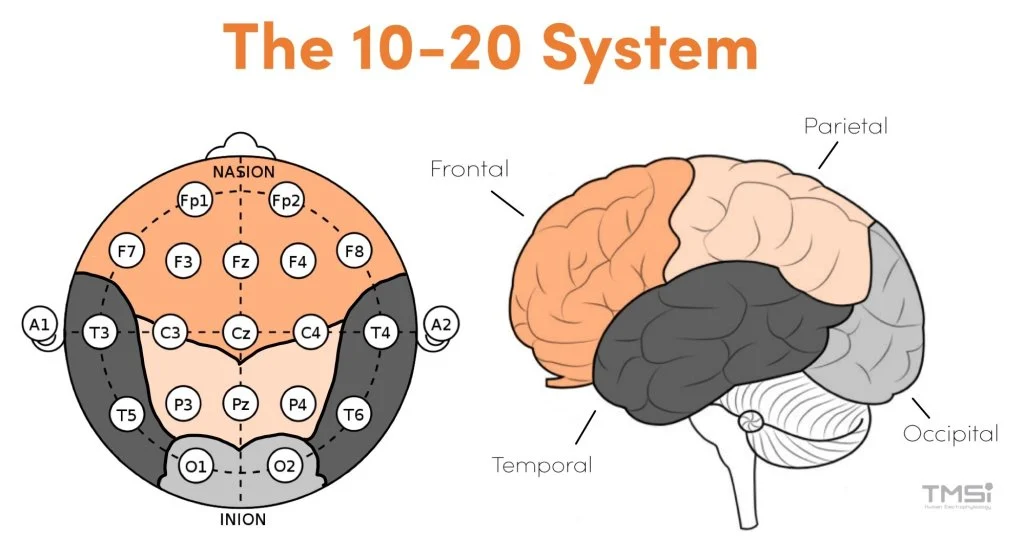
**Figure 1: The electrode layout of the 10-20 system (left) and corresponding brain regions (right)** ([Source](https://info.tmsi.com/blog/the-10-20-system-for-eeg))

In [ ]:
# Load an EEG file
eeg = pd.read_parquet('/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/1484166292.parquet')
eeg

In [ ]:
# List of columns to plot
columns_to_plot = [
    'Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 
    'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG'
]

# Determine the number of rows/columns needed for subplots
num_plots = len(columns_to_plot)
num_columns = 2  # Set to 2 as per the previous code
num_rows = num_plots // num_columns + (num_plots % num_columns > 0)

# Create subplots
fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, num_rows * 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each column in a subplot
for i, col in enumerate(columns_to_plot):
    axes[i].plot(eeg[col])
    axes[i].set_title(f'Electrode: {col}', fontsize=14)

# Hide any unused subplots
for ax in axes[len(columns_to_plot):]:
    ax.set_visible(False)

# Set the overall figure title
fig.suptitle('EEG Data Visualization Based on the International 10-20 System', fontsize=30, y=1.02)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

As expected, a lot of the electrode location readings are correlated with one another as shown below.

In [ ]:
# Correlation Analysis
corr_matrix = eeg.corr()

# Increase the size of the figure
plt.figure(figsize=(16, 8)) 

# Heatmap for correlation analysis
# We are using 'coolwarm' colormap here to distinguish positive and negative correlations easily
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.title('Pearson Correlation of the Individual Electrode Readings for EEG leads', fontsize=20)
plt.show()

## **Feature Engineering of EEG Data**

### Time-based Features for EEG Data Analysis

The function `calculate_time_domain_features` computes several time-domain features for each channel in EEG (Electroencephalography) data. These features are crucial for understanding the characteristics of EEG signals. Below is a brief description of each feature:

#### Mean (`mean`)
- Represents the **average value** of the EEG signal for each channel.
- Provides an idea of the **central tendency** of the signal amplitude.

#### Standard Deviation (`std`)
- Measures the **variation or dispersion** of the EEG signal from its mean.
- A high standard deviation indicates that the signal varies widely from the mean, and vice versa.

#### Maximum (`max`)
- The **highest value** in the EEG signal for each channel.
- Useful for identifying spikes or peaks, which are common in seizure activity.

#### Minimum (`min`)
- The **lowest value** in the EEG signal for each channel.
- Helps in understanding the range of the signal.

#### Skewness (`skewness`)
- Measures the **asymmetry** of the EEG signal distribution.
- A zero value indicates a symmetrical distribution, while a non-zero value suggests asymmetry, indicating potential abnormal brain activity.

#### Kurtosis (`kurtosis`)
- Quantifies the **tails of the distribution** of the EEG signal.
- A high kurtosis value indicates heavy tails, suggesting a significant number of extreme deviation values, common in erratic signals such as those seen in seizure activities.

These features collectively provide a comprehensive profile of each EEG channel's time-domain characteristics, instrumental in automated EEG analysis for detecting abnormalities in brain activities.

In [ ]:
from scipy.stats import skew, kurtosis

def calculate_time_domain_features(eeg_data):
    """
    Calculate time domain features for each channel in the EEG data.

    Parameters:
    eeg_data (pandas.DataFrame): A DataFrame with each column representing an EEG channel.

    Returns:
    pandas.DataFrame: A DataFrame with time domain features for each channel.
    """
    features_dict = {}

    # Calculate features for each channel
    for column in eeg_data.columns:
        features_dict[f'{column}_mean'] = [eeg_data[column].mean()]
        features_dict[f'{column}_std'] = [eeg_data[column].std()]
        features_dict[f'{column}_max'] = [eeg_data[column].max()]
        features_dict[f'{column}_min'] = [eeg_data[column].min()]
        features_dict[f'{column}_skewness'] = [skew(eeg_data[column])]
        features_dict[f'{column}_kurtosis'] = [kurtosis(eeg_data[column])]

    # Create a DataFrame from the dictionary
    features_df = pd.DataFrame(features_dict)

    return features_df

In [ ]:
time_domain_features = calculate_time_domain_features(eeg)
time_domain_features

In [ ]:
# Visualization function to create subplots for each feature type
def visualize_features_subplots(features_df):
    # Flatten the DataFrame for easier plotting
    flat_data = features_df.T.reset_index()
    flat_data.columns = ['Feature', 'Value']

    # Split the features into categories
    feature_types = ['mean', 'std', 'max', 'min', 'skewness', 'kurtosis']
    fig, axes = plt.subplots(nrows=len(feature_types), ncols=1, figsize=(10, 20))

    for i, feature_type in enumerate(feature_types):
        ax = axes[i]
        filtered_data = flat_data[flat_data['Feature'].str.contains(feature_type)]
        ax.barh(filtered_data['Feature'], filtered_data['Value'])
        ax.set_title(f'{feature_type.capitalize()} of EEG Channels')
        ax.set_xlabel('Value')
        ax.set_ylabel('Channel')

    plt.tight_layout()
    plt.show()

# Call the function with the time_domain_features DataFrame
visualize_features_subplots(time_domain_features)

### Peak Analysis in EEG

- **Purpose**: Peak analysis in EEG aims to identify and quantify prominent features, often referred to as 'peaks' or 'spikes'.
- **Seizure Detection**: Peaks or spikes in EEG are key indicators of abnormal brain activity, like seizures. Seizures typically manifest as sharp spikes in the EEG signal.
- **Implementation**: The `find_peaks` function from `scipy.signal` detects these peaks. Parameters such as `height` and `distance` can be adjusted to control peak detection sensitivity.
- **Outcome**: This function returns the indices of peaks, which can then be counted or further analyzed.

### Hjorth Parameters in EEG

- **Overview**: Hjorth parameters are statistical measures used to characterize EEG signals, including Activity, Mobility, and Complexity:
  - **Activity**: Represents signal power, calculated as the variance of the signal. Indicates the overall level of brain activity in EEG.
  - **Mobility**: Measures the mean frequency or rate of change of the signal. Higher mobility suggests more rapid signal changes.
  - **Complexity**: Compares the signal's similarity to a pure sine wave. Higher values indicate a more complex signal.
- **Implementation**: The `hjorth_parameters` function calculates these parameters using raw EEG data.
- **Usage**: These parameters help distinguish different brain activities and are useful in identifying changes in brain states, such as during sleep stages or in response to stimuli.

### Application in `calculate_features` Function

- The function applies peak analysis and Hjorth parameter calculations to each EEG channel in a DataFrame.
- It returns a DataFrame with columns representing peak count, activity, mobility, and complexity for each EEG channel.
- Useful for generating a comprehensive feature set from raw EEG data for analysis, such as in seizure detection or neurophysiological studies.

In [ ]:
import scipy.signal

def find_peaks(data, height=None, distance=None):
    """Identify peaks in the EEG signal."""
    peaks, _ = scipy.signal.find_peaks(data, height=height, distance=distance)
    return peaks

def hjorth_parameters(data):
    """Calculate Hjorth parameters: Activity, Mobility, and Complexity."""
    activity = np.var(data)
    mobility = np.sqrt(np.var(np.diff(data)) / activity)
    complexity = np.sqrt(np.var(np.diff(np.diff(data))) / np.var(np.diff(data))) / mobility
    return activity, mobility, complexity

def calculate_features(eeg_df):
    """
    Calculate peaks and Hjorth parameters for each EEG channel.

    Parameters:
    eeg_df (pandas.DataFrame): DataFrame with each column representing an EEG channel.

    Returns:
    pandas.DataFrame: A single-row DataFrame containing peaks and Hjorth parameters for each channel.
    """
    features = {}

    for column in eeg_df.columns:
        data = eeg_df[column]
        
        # Peak analysis
        peaks = find_peaks(data)
        features[f'{column}_peak_count'] = len(peaks)

        # Hjorth parameters
        activity, mobility, complexity = hjorth_parameters(data)
        features[f'{column}_activity'] = activity
        features[f'{column}_mobility'] = mobility
        features[f'{column}_complexity'] = complexity

    return pd.DataFrame([features])

In [ ]:
eeg_features = calculate_features(eeg)
eeg_features

The figure below shows the values for different EEG features: **peak counts, activities, mobilities, and complexities** for each EEG channel. Each subplot represents a different feature category, and within each subplot, each bar corresponds to a specific EEG channel.

- The first subplot shows the peak counts for each EEG channel.
- The second subplot illustrates the activity levels.
- The third subplot depicts the mobility values.
- The fourth subplot displays the complexity measurements.

This visualization provides an overview of these key EEG features across different channels, which can be useful for understanding the characteristics of the EEG signals in different regions of the brain

In [ ]:
# Plotting
fig, axs = plt.subplots(4, figsize=(10, 15))

# Peak Counts
axs[0].bar(eeg_features.columns[eeg_features.columns.str.contains('peak_count')], eeg_features.iloc[0, eeg_features.columns.str.contains('peak_count')])
axs[0].set_title('Peak Counts')
axs[0].set_ylabel('Count')
axs[0].tick_params(axis='x', rotation=45)

# Activities
axs[1].bar(eeg_features.columns[eeg_features.columns.str.contains('activity')], eeg_features.iloc[0, eeg_features.columns.str.contains('activity')])
axs[1].set_title('Activities')
axs[1].set_ylabel('Activity Value')
axs[1].tick_params(axis='x', rotation=45)

# Mobilities
axs[2].bar(eeg_features.columns[eeg_features.columns.str.contains('mobility')], eeg_features.iloc[0, eeg_features.columns.str.contains('mobility')])
axs[2].set_title('Mobilities')
axs[2].set_ylabel('Mobility Value')
axs[2].tick_params(axis='x', rotation=45)

# Complexities
axs[3].bar(eeg_features.columns[eeg_features.columns.str.contains('complexity')], eeg_features.iloc[0, eeg_features.columns.str.contains('complexity')])
axs[3].set_title('Complexities')
axs[3].set_ylabel('Complexity Value')
axs[3].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## **Spectrogram Data**

### `train_spectrograms` 

The `train_spectrograms` directory contains spectrograms of the assembled EEG data. To investigate specific annotated subsets, utilize the metadata available in `train.csv`.

#### Column Descriptions

- The column names represent the frequency in hertz and the recording regions of the EEG electrodes.
- The recording regions are abbreviated as follows:
  - `LL`: Left Lateral
  - `RL`: Right Lateral
  - `LP`: Left Parasagittal
  - `RP`: Right Parasagittal


In [ ]:
# Load a Spectrogram file
spectrogram = pd.read_parquet('/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/862174834.parquet')
spectrogram

In [ ]:
def plot_spec_at_frequencies(df_spec, frequencies, handle_missing='ignore'):
    """
    Plots the data at multiple frequencies for different features.

    Parameters:
    df_spec (pandas.DataFrame): The DataFrame containing the spectral data.
    frequencies (list): A list of frequencies to plot (e.g., ['0.59', '1.17', etc.]).
    handle_missing (str): How to handle missing data ('ignore', 'drop').
    """
    features = ['LL', 'RL', 'RP', 'LP']

    # Create subplots - one row for each frequency
    fig, axes = plt.subplots(len(frequencies), 1, figsize=(12, 4 * len(frequencies)), squeeze=False)

    # Iterate over frequencies to create subplots
    for i, freq in enumerate(frequencies):
        ax = axes[i][0]  # Current axes

        # Feature columns for the current frequency
        feature_columns = [f'{feature}_{freq}' for feature in features]

        # Check if all required columns are present in the DataFrame
        missing_columns = [col for col in feature_columns if col not in df_spec.columns]
        if missing_columns:
            raise ValueError(f'Missing columns for frequency {freq}: {missing_columns}')

        # Handling missing data
        if handle_missing == 'drop':
            df_spec_freq = df_spec.dropna(subset=feature_columns)
        else:
            df_spec_freq = df_spec

        # Plot each feature
        for j, feature in enumerate(feature_columns):
            ax.scatter(df_spec_freq['time'], df_spec_freq[feature], label=features[j])

        # Add legend, title, and grid
        ax.legend(loc='upper right')
        ax.set_title(f'Frequency = {freq}', fontsize=14)
        ax.set_xlabel('Time')
        ax.set_ylabel('Amplitude')
        ax.grid()

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [ ]:
# Example usage
plot_spec_at_frequencies(spectrogram, ['0.59', '18.95'], handle_missing='drop')  

Function `plot_spectrogram` below adapted from: https://www.kaggle.com/code/clehmann10/plot-spectrograms

In [ ]:
def plot_spectrogram(spectrogram_path, colormap='viridis', aspect='auto', label_interval=None):
    try:
        sample_spect = pd.read_parquet(spectrogram_path)
    except Exception as e:
        print(f"Error loading file: {e}")
        return

    split_spect = {
        "LL": sample_spect.filter(regex='^LL', axis=1),
        "RL": sample_spect.filter(regex='^RL', axis=1),
        "RP": sample_spect.filter(regex='^RP', axis=1),
        "LP": sample_spect.filter(regex='^LP', axis=1),
    }
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
    axes = axes.flatten()

    for i, split_name in enumerate(split_spect.keys()):
        ax = axes[i]
        spect_data = np.log(split_spect[split_name] + 1e-9).T  # Adding a small constant to avoid log(0)
        img = ax.imshow(spect_data, cmap=colormap, aspect=aspect, origin='lower')
        
        cbar = fig.colorbar(img, ax=ax)
        cbar.set_label('Log(Value)', rotation=270, labelpad=15)
        ax.set_title(split_name)
        ax.set_ylabel("Frequency (Hz)")
        ax.set_xlabel("Time")

        frequencies = [column_name[3:] for column_name in split_spect[split_name].columns]
        if label_interval is None:
            label_interval = max(1, len(frequencies) // 15)  # Dynamic label interval
        ax.set_yticks(np.arange(0, len(frequencies), label_interval))
        ax.set_yticklabels(frequencies[::label_interval])

    plt.tight_layout()
    plt.show()

In [ ]:
plot_spectrogram("/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/862174834.parquet")

## **To Be Continued**

I will continue to update and improve this notebook. I hope it has been useful and provides a great baseline to work with for future analysis! 